<a href="https://colab.research.google.com/github/prachimodi-142/Card/blob/master/Assignment_04_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 57000 Assignment 4 Exercise

Your Name: Prachi Modi

## Exercise 0: Train your model on GPU (0 points)

For some tasks in this assignment, it can take a long time if you run it on CPU. For example, based on our test on Exercise 3 Task 4, it will take roughly 2 hours to train the full model for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.



In [ ]:
import torch
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [ ]:
import torch.nn as nn
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device
rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)
# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


Here is a helper function to print the accuracy given a model and loader

In [ ]:
def print_accuracy(model, test_loader):
  # Note device should be defined globally from the previous cell
  model.to(device)
  correct, total = 0, 0
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Following the structure used in the instructions, you should create

*   One network named **OurFC** which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named **OurCNN** which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions
* You are **required** to print out the loss in the training and loss+accuracy in the test as in the instructions.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)

In [ ]:
# Parameters
input_size = 784
hidden_size = 200
num_classes = 10
learning_rate = 0.01
batch_size_train = 64
batch_size_test = 1000

In [ ]:
# Data Loader for MNIST Dataset

import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=False)

print(train_dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [ ]:
batch_idx, (images, targets) = next(enumerate(train_loader))
print(f'current batch index is {batch_idx}')
print(f'images has shape {images.size()}')
print(f'targets has shape {targets.size()}')

current batch index is 0
images has shape torch.Size([64, 1, 28, 28])
targets has shape torch.Size([64])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Fully connected neural network
class OurFC(nn.Module):
    def __init__(self, input_size=784, hidden_size=200, num_classes=10):
        super(OurFC, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

ourfc = OurFC(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ourfc.parameters(), lr=0.01, momentum=0.8)

In [ ]:
max_epoch = 3
# Train the model
total_step = len(train_loader)
ourfc.train()
for epoch in range(max_epoch):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = ourfc(images)
        loss = loss_func(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print(f'Epoch {epoch+1}: [{i*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)

ourfc.eval()
with torch.no_grad():
    correct = 0
    test_loss = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = ourfc(images)
        test_loss += F.cross_entropy(outputs, labels, reduction='sum').item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'Test result on epoch {epoch+1}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

Epoch 1: [0/60000] Loss: 2.3641343116760254
Epoch 1: [6400/60000] Loss: 0.5891022086143494
Epoch 1: [12800/60000] Loss: 0.2884142994880676
Epoch 1: [19200/60000] Loss: 0.18962767720222473
Epoch 1: [25600/60000] Loss: 0.19178329408168793
Epoch 1: [32000/60000] Loss: 0.20413628220558167
Epoch 1: [38400/60000] Loss: 0.2893921434879303
Epoch 1: [44800/60000] Loss: 0.16354063153266907
Epoch 1: [51200/60000] Loss: 0.21832728385925293
Epoch 1: [57600/60000] Loss: 0.2677666246891022
Epoch 2: [0/60000] Loss: 0.32205209136009216
Epoch 2: [6400/60000] Loss: 0.25004369020462036
Epoch 2: [12800/60000] Loss: 0.21090586483478546
Epoch 2: [19200/60000] Loss: 0.1557510942220688
Epoch 2: [25600/60000] Loss: 0.07823650538921356
Epoch 2: [32000/60000] Loss: 0.16151615977287292
Epoch 2: [38400/60000] Loss: 0.18549984693527222
Epoch 2: [44800/60000] Loss: 0.06029805913567543
Epoch 2: [51200/60000] Loss: 0.12005260586738586
Epoch 2: [57600/60000] Loss: 0.09066401422023773
Epoch 3: [0/60000] Loss: 0.130508556

In [ ]:
# Convolutional neural network (two convolutional layers)
class OurCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(OurCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

ourcnn = OurCNN(num_classes).to(device)

# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ourcnn.parameters(), lr=learning_rate)

In [ ]:
max_epoch = 3
# Train the model
total_step = len(train_loader)
ourcnn.train()
for epoch in range(max_epoch):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = ourcnn(images)
        loss = loss_func(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print(f'Epoch {epoch+1}: [{i*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)

ourcnn.eval()
with torch.no_grad():
    correct = 0
    test_loss = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = ourcnn(images)
        test_loss += F.cross_entropy(outputs, labels, reduction='sum').item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'Test result on epoch {epoch+1}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

Epoch 1: [0/60000] Loss: 2.351029396057129
Epoch 1: [6400/60000] Loss: 0.7598375678062439
Epoch 1: [12800/60000] Loss: 0.330857515335083
Epoch 1: [19200/60000] Loss: 0.4593142569065094
Epoch 1: [25600/60000] Loss: 0.22372187674045563
Epoch 1: [32000/60000] Loss: 0.3242632746696472
Epoch 1: [38400/60000] Loss: 0.09722723066806793
Epoch 1: [44800/60000] Loss: 0.08651991933584213
Epoch 1: [51200/60000] Loss: 0.2382875680923462
Epoch 1: [57600/60000] Loss: 0.10674804449081421
Epoch 2: [0/60000] Loss: 0.18886561691761017
Epoch 2: [6400/60000] Loss: 0.17673611640930176
Epoch 2: [12800/60000] Loss: 0.21631300449371338
Epoch 2: [19200/60000] Loss: 0.05918968468904495
Epoch 2: [25600/60000] Loss: 0.11956395208835602
Epoch 2: [32000/60000] Loss: 0.044836126267910004
Epoch 2: [38400/60000] Loss: 0.14044426381587982
Epoch 2: [44800/60000] Loss: 0.08914348483085632
Epoch 2: [51200/60000] Loss: 0.14267396926879883
Epoch 2: [57600/60000] Loss: 0.07359713315963745
Epoch 3: [0/60000] Loss: 0.1981407999

In [ ]:
# ----------- <Your code> ---------------

# ----------- <End Your code> ---------------

ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

OurFC has a total of 159010 parameters
OurCNN has a total of 28938 parameters


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders 
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


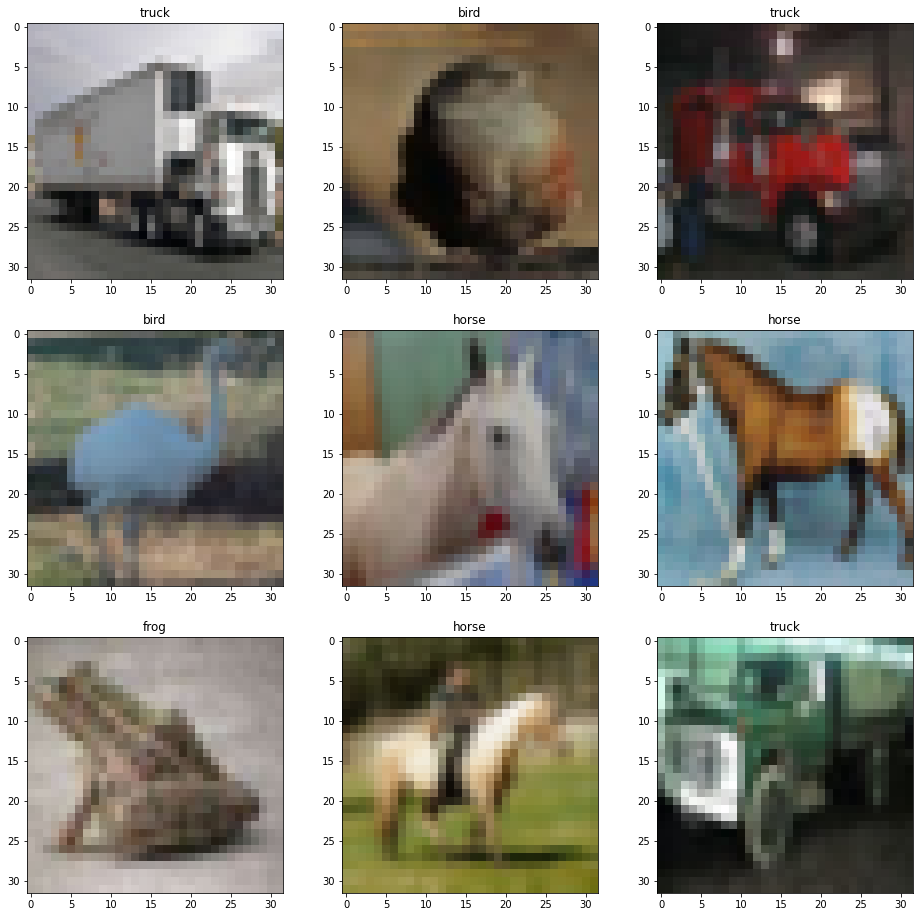

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

batch_size = 9

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# ----------- <End Your code> ---------------

# Define train_loader and test_loader
# ----------- <Your code> ---------------
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader))
fig, ax = plt.subplots(3,3,figsize = (16,16))
fig.set_size_inches(16,16)
for i in range(3):
  for j in range(3):
    image = images[i*3+j].permute(1,2,0)
    image = image/2 + 0.5
    ax[i,j].imshow(image)
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [ ]:
# ----------- <Your code> ---------------
import torch.nn as nn
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net = net.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

max_epoch = 3
# Train the model
total_step = len(train_loader)
net.train()
for epoch in range(max_epoch):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = net(images)
        loss = loss_func(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print(f'Epoch {epoch+1}: [{i*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)
misclassified = []

net.eval()
with torch.no_grad():
    correct = 0
    test_loss = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        test_loss += F.cross_entropy(outputs, labels, reduction='sum').item()
        _, predicted = torch.max(outputs.data, 1)

        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'Test result on epoch {epoch+1}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')
# ----------- <End Your code> ---------------

# This prints the accuracy of your model. 
print_accuracy(net, test_loader)

Epoch 1: [0/50000] Loss: 2.250335931777954
Epoch 1: [900/50000] Loss: 2.3090243339538574
Epoch 1: [1800/50000] Loss: 2.277477264404297
Epoch 1: [2700/50000] Loss: 2.285922050476074
Epoch 1: [3600/50000] Loss: 2.299201726913452
Epoch 1: [4500/50000] Loss: 2.2971079349517822
Epoch 1: [5400/50000] Loss: 2.2872395515441895
Epoch 1: [6300/50000] Loss: 2.292125701904297
Epoch 1: [7200/50000] Loss: 2.2570908069610596
Epoch 1: [8100/50000] Loss: 2.228307008743286
Epoch 1: [9000/50000] Loss: 2.2087202072143555
Epoch 1: [9900/50000] Loss: 2.0964298248291016
Epoch 1: [10800/50000] Loss: 2.241042137145996
Epoch 1: [11700/50000] Loss: 1.7854851484298706
Epoch 1: [12600/50000] Loss: 2.2049484252929688
Epoch 1: [13500/50000] Loss: 2.046616554260254
Epoch 1: [14400/50000] Loss: 1.664259433746338
Epoch 1: [15300/50000] Loss: 2.1115479469299316
Epoch 1: [16200/50000] Loss: 2.177534341812134
Epoch 1: [17100/50000] Loss: 2.0633132457733154
Epoch 1: [18000/50000] Loss: 1.802795648574829
Epoch 1: [18900/500

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

In [ ]:
data = []
count = 0
for i, (image, labels) in enumerate(test_loader):
  images = images.to(device)
  labels = labels.to(device)
  pred = net(images.to(device))

  _, predicted = torch.max(pred.data, 1)
  temp = [(images[x],predicted[x].item(),classes[predicted[x].item()],classes[labels[x].item()],y)for x,y in enumerate((predicted == labels)) if y == False]

  for d in temp:
    data.append(d)
  
  if count == 10:
    break
  count+=1

In [ ]:
net.eval()
with torch.no_grad():
    correct = 0
    test_loss = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        test_loss += F.cross_entropy(outputs, labels, reduction='sum').item()
        _, predicted = torch.max(outputs.data, 1)

        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
# ----------- <Your code> ---------------
# i, (images, labels) = next(enumerate(test_loader)) # get a batch from test data loader
# images = images.to(device)
# labels = labels.to(device)
# pred = net(images.to(device))

# _, predicted = torch.max(pred.data, 1)

# data = [(images[x],predicted[x].item(),classes[predicted[x].item()],classes[labels[x].item()],y)for x,y in enumerate((predicted == labels)) if y == False]

# Code to display images
fig, ax = plt.subplots(3,figsize = (16,16))
fig.set_size_inches(16,16)
for i in range(3):
  image = data[i][0].detach().cpu().permute(1,2,0)
  image = image/2 + 0.5
  ax[i].imshow(image)
  ax[i].set_title(f'TRUE: {data[i][2]}| PRED: {data[i][3]}')
fig.show()

Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import time

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [ ]:
resnet18 = models.resnet18(pretrained=True)

### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [ ]:
# ----------- <Your code> ---------------
batch_size = 9
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose([transforms.ToTensor(),
     transforms.Resize((224,224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Define train_loader and test_loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader))
fig, ax = plt.subplots(3,3,figsize = (16,16))
fig.set_size_inches(16,16)
for i in range(3):
  for j in range(3):
    image = images[i*3+j].permute(1,2,0)
    image = image/2 + 0.5
    ax[i,j].imshow(image)
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [ ]:
# ----------- <Your code> ---------------
# This prints the accuracy of your model. 
print_accuracy(resnet18, test_loader)
# ----------- <End Your code> ---------------



### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [ ]:
# ----------- <Your code> ---------------
resnet18 = resnet18.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

max_epoch = 3
# Train the model
total_step = len(train_loader)
resnet18.train()
for epoch in range(max_epoch):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet18(images)
        loss = loss_func(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print(f'Epoch {epoch+1}: [{i*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')
# ----------- <End Your code> ---------------
  
print_accuracy(resnet18, test_loader)